In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import pycaret

This notebook is for evaluation of the Extra Trees Regressor and the Light Gradient Boosting Machine, after the two were determined to be the best classical machine learning models for this regression problem.

In [2]:
ds = xr.open_dataset('/home/giantstep5/rjones98/meteorology/ESS569/ai_ready/AI_ready_dataset.nc')
ds = ds.drop_vars(['BCSMASS', 'DUCMASS25', 'DUSMASS', 'DUSMASS25', 'OCSMASS', 'SO2SMASS', 'SO4SMASS', 'SSCMASS25', 'SSSMASS', 'SSSMASS25', 'energy'])
ds_jja = ds.sel(time=slice('2023-06-01', '2023-08-31'))
df_jja = ds_jja.to_dataframe().reset_index()
df_jja.drop(columns=['ltg'])

,time,lat,lon,cape,precipitation,BCCMASS,DUCMASS,OCCMASS,SO2CMASS,SO4CMASS,SSCMASS
0,2023-06-01 00:00:00,24.5,-125.000,6.524974,0.000000,3.146680e-07,0.000040,0.000001,1.585380e-07,0.000002,0.000003
1,2023-06-01 00:00:00,24.5,-124.375,11.108364,0.000000,3.154829e-07,0.000038,0.000001,1.529694e-07,0.000002,0.000004
2,2023-06-01 00:00:00,24.5,-123.750,10.432619,0.000033,3.147456e-07,0.000037,0.000001,1.533769e-07,0.000002,0.000004
3,2023-06-01 00:00:00,24.5,-123.125,6.817513,0.000207,3.144740e-07,0.000037,0.000001,1.540366e-07,0.000002,0.000005
4,2023-06-01 00:00:00,24.5,-122.500,4.350946,0.000000,3.147456e-07,0.000037,0.000001,1.583439e-07,0.000002,0.000006
...,...,...,...,...,...,...,...,...,...,...,...
3597563,2023-08-31 21:00:00,50.0,-69.375,4.815889,0.000000,4.740354e-07,0.000008,0.000005,1.817694e-07,0.000002,0.000001
3597564,2023-08-31 21:00:00,50.0,-68.750,6.956883,0.000000,4.699221e-07,0.000008,0.000005,1.563521e-07,0.000002,0.000002
3597565,2023-08-31 21:00:00,50.0,-68.125,6.734576,0.000000,4.739578e-07,0.000008,0.000005,1.362316e-07,0.000002,0.000003
3597566,2023-08-31 21:00:00,50.0,-67.500,6.704780,0.000000,4.937872e-07,0.000008,0.000006,1.374540e-07,0.000002,0.000005


# Extra Trees

In [4]:
from pycaret.regression import *
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import r2_score

start_time = time.time()

# Split the data into train and test sets
train, test = train_test_split(df_jja, test_size=0.2, random_state=13)

# Run PyCaret setup on the training set
exp_name = setup(data=train, target='ltg', session_id=13, 
                         normalize=True, use_gpu=False)

# Train the model
et_model = create_model('et')
et_final = finalize_model(et_model)

# Predict on the test set
test_predictions = predict_model(et_final, data=test)

end_time = time.time()
elapsed_time = end_time - start_time

# Calculate R^2 on the test set
r2_test = r2_score(test_predictions['ltg'], test_predictions['prediction_label'])
print(f"Test R^2 value: {r2_test:.4f}")
print(f"Time taken to run the model: {elapsed_time:.2f} seconds")



,Description,Value
0,Session id,13
1,Target,ltg
2,Target type,Regression
3,Original data shape,"(2878054, 12)"
4,Transformed data shape,"(2878054, 14)"
5,Transformed train set shape,"(2014637, 14)"
6,Transformed test set shape,"(863417, 14)"
7,Numeric features,10
8,Date features,1
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0012,0.0001,0.0112,0.4640,0.0085,6.9261
1,0.0012,0.0001,0.0095,0.4620,0.0081,7.4332
2,0.0012,0.0001,0.0105,0.4110,0.0085,6.5985
3,0.0012,0.0001,0.0098,0.4871,0.0082,6.2437
4,0.0012,0.0001,0.0096,0.4968,0.0080,6.2954
5,0.0012,0.0001,0.0104,0.4438,0.0085,6.8166
6,0.0012,0.0001,0.0104,0.4383,0.0084,6.8991
7,0.0012,0.0001,0.0097,0.4633,0.0081,6.5462
8,0.0012,0.0001,0.0107,0.4280,0.0087,6.6432


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0011,0.0001,0.0094,0.4806,0.0079,6.4005


Test R^2 value: 0.4806
Time taken to run the model: 384.10 seconds


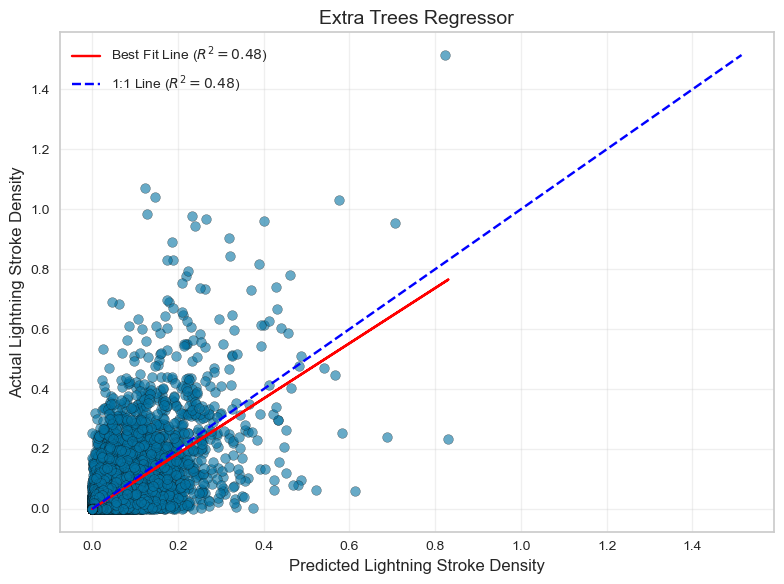

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Define actual (y) and predicted (x) values
x = test_predictions['prediction_label']
y = test_predictions['ltg']

# Calculate the best fit line
slope, intercept = np.polyfit(x, y, 1)
best_fit_line = slope * x + intercept

# Calculate the 1:1 line (perfect agreement line)
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
one_to_one_line = [min_val, max_val]

# Calculate R^2 for best fit line and 1:1 line
r2_best_fit = r2_score(y, best_fit_line)
r2_one_to_one = r2_score(y, x)  # For 1:1 line, predicted = actual

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, edgecolor='k')

# Plot the best fit line
plt.plot(x, best_fit_line, color='red', label=f"Best Fit Line ($R^2 = {r2_best_fit:.2f}$)")

# Plot the 1:1 trend line
plt.plot(one_to_one_line, one_to_one_line, color='blue', linestyle='--', label=f"1:1 Line ($R^2 = {r2_one_to_one:.2f}$)")

# Add labels, title, and legend
plt.xlabel("Predicted Lightning Stroke Density", fontsize=12)
plt.ylabel("Actual Lightning Stroke Density", fontsize=12)
plt.title("Extra Trees Regressor", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()


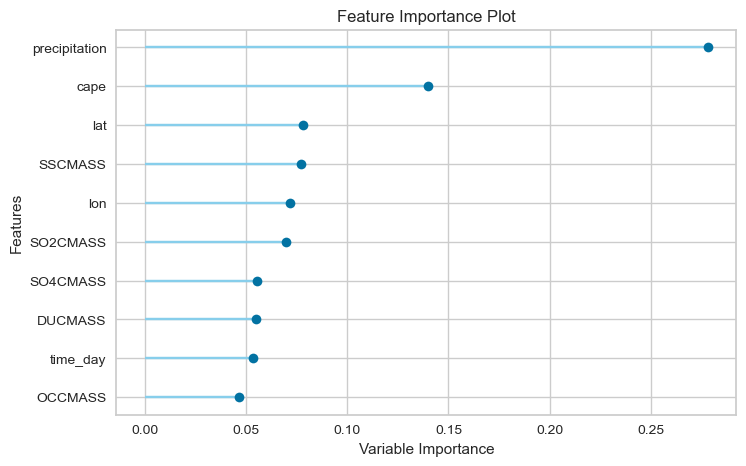

In [25]:
from pycaret.regression import plot_model

# Plot feature importance for the finalized Extra Trees model
plot_model(et_final, plot='feature')


# Light Gradient Boosting Machine

In [6]:
# Split the data into train and test sets
#train, test = train_test_split(df_jja, test_size=0.2, random_state=13)

# Run PyCaret setup on the training set
#exp_name = setup(data=train, target='ltg', session_id=13, 
#                         normalize=True, use_gpu=False)

# Train the model
lgbm_model = create_model('lightgbm')
lgbm_final = finalize_model(lgbm_model)

# Predict on the test set
test_predictions = predict_model(lgbm_final, data=test)

# Calculate R^2 on the test set
r2_test = r2_score(test_predictions['ltg'], test_predictions['prediction_label'])
print(f"Test R^2 value: {r2_test:.4f}")


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0012,0.0001,0.0114,0.4434,0.0087,6.2700
1,0.0012,0.0001,0.0097,0.4429,0.0082,6.3824
2,0.0012,0.0001,0.0107,0.3877,0.0086,5.7490
3,0.0012,0.0001,0.0104,0.4283,0.0086,5.4238
4,0.0012,0.0001,0.0098,0.4745,0.0082,5.5188
5,0.0012,0.0001,0.0109,0.3969,0.0087,6.0223
6,0.0012,0.0001,0.0104,0.4413,0.0085,5.9459
7,0.0012,0.0001,0.0100,0.4295,0.0083,5.8606
8,0.0012,0.0001,0.0111,0.3878,0.0090,5.7252


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0012,0.0001,0.0098,0.4336,0.0082,5.7408


Test R^2 value: 0.4336


In [28]:
import time
from sklearn.metrics import r2_score

# Start the timer
start_time = time.time()

exp_name = setup(data=train, target='ltg', session_id=13, 
                         normalize=True, use_gpu=False)

# Create and finalize the LightGBM model
lgbm_model = create_model('lightgbm')
lgbm_final = finalize_model(lgbm_model)

# Predict on the test set
test_predictions = predict_model(lgbm_final, data=test)

# Calculate R^2 on the test set
r2_test = r2_score(test_predictions['ltg'], test_predictions['prediction_label'])
print(f"Test R^2 value: {r2_test:.4f}")

# End the timer and calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Time taken to run the model: {elapsed_time:.2f} seconds")


,Description,Value
0,Session id,13
1,Target,ltg
2,Target type,Regression
3,Original data shape,"(2878054, 12)"
4,Transformed data shape,"(2878054, 14)"
5,Transformed train set shape,"(2014637, 14)"
6,Transformed test set shape,"(863417, 14)"
7,Numeric features,10
8,Date features,1
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0012,0.0001,0.0114,0.4434,0.0087,6.2700
1,0.0012,0.0001,0.0097,0.4429,0.0082,6.3824
2,0.0012,0.0001,0.0107,0.3877,0.0086,5.7490
3,0.0012,0.0001,0.0104,0.4283,0.0086,5.4238
4,0.0012,0.0001,0.0098,0.4745,0.0082,5.5188
5,0.0012,0.0001,0.0109,0.3969,0.0087,6.0223
6,0.0012,0.0001,0.0104,0.4413,0.0085,5.9459
7,0.0012,0.0001,0.0100,0.4295,0.0083,5.8606
8,0.0012,0.0001,0.0111,0.3878,0.0090,5.7252


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0012,0.0001,0.0098,0.4336,0.0082,5.7408


Test R^2 value: 0.4336
Time taken to run the model: 55.04 seconds


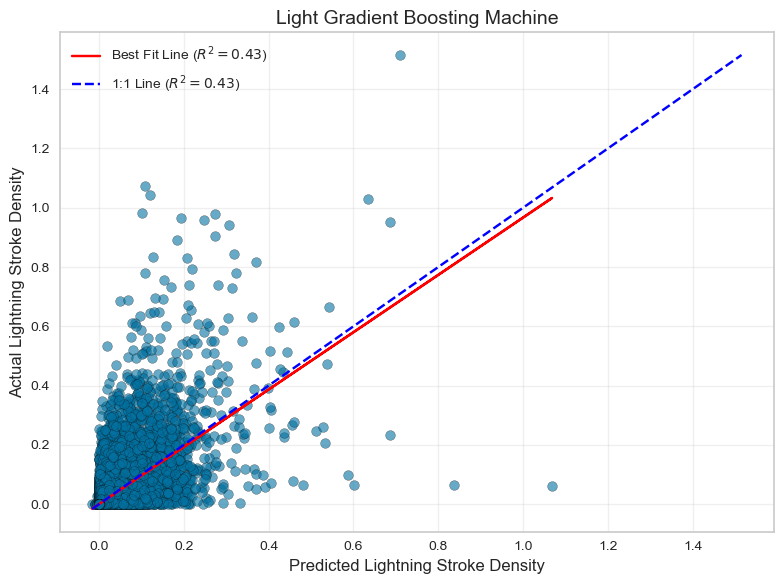

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Define actual (y) and predicted (x) values
x = test_predictions['prediction_label']
y = test_predictions['ltg']

# Calculate the best fit line
slope, intercept = np.polyfit(x, y, 1)
best_fit_line = slope * x + intercept

# Calculate the 1:1 line (perfect agreement line)
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
one_to_one_line = [min_val, max_val]

# Calculate R^2 for best fit line and 1:1 line
r2_best_fit = r2_score(y, best_fit_line)
r2_one_to_one = r2_score(y, x)  # For 1:1 line, predicted = actual

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, edgecolor='k')

# Plot the best fit line
plt.plot(x, best_fit_line, color='red', label=f"Best Fit Line ($R^2 = {r2_best_fit:.2f}$)")

# Plot the 1:1 trend line
plt.plot(one_to_one_line, one_to_one_line, color='blue', linestyle='--', label=f"1:1 Line ($R^2 = {r2_one_to_one:.2f}$)")

# Add labels, title, and legend
plt.xlabel("Predicted Lightning Stroke Density", fontsize=12)
plt.ylabel("Actual Lightning Stroke Density", fontsize=12)
plt.title("Light Gradient Boosting Machine", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()


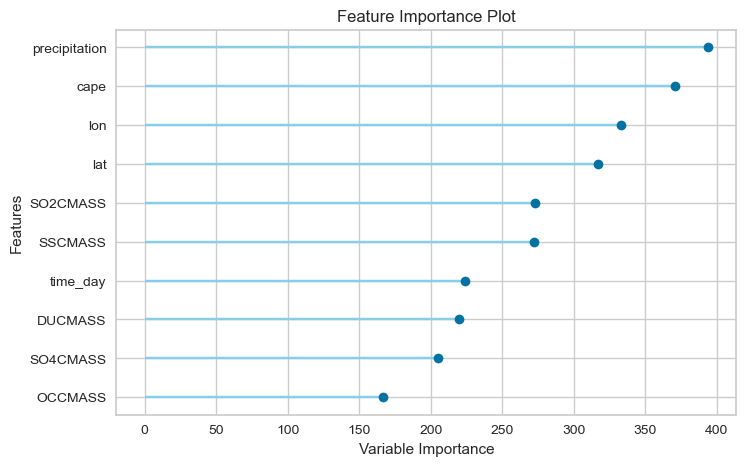

In [30]:
from pycaret.regression import plot_model

# Plot feature importance for the finalized Light Gradient Boosting Mahcine model
plot_model(lgbm_final, plot='feature')


The above plot has feature importances that range from 0 to 400, instead of 0 to 1, so those will be converted below.

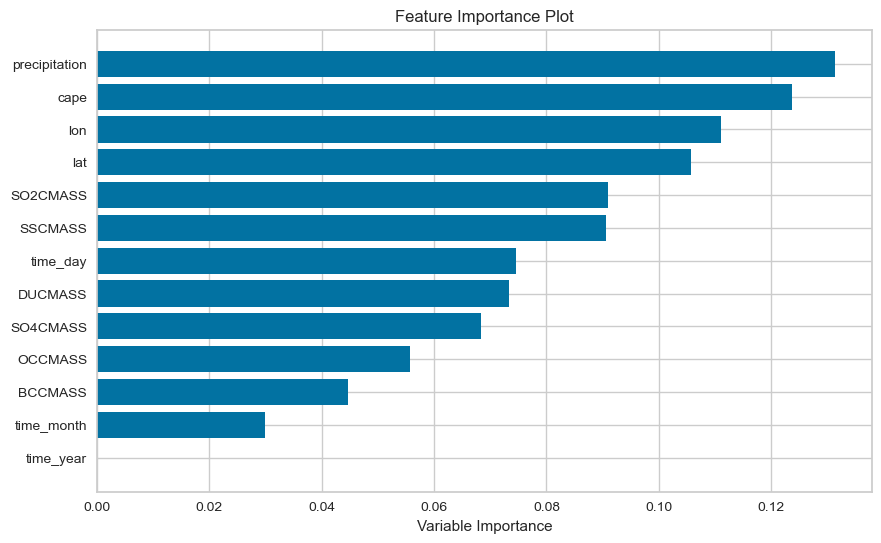

In [35]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np

# Get the feature importances from the model
importances = lgbm_final.feature_importances_

# Normalize to percentage
importances_percentage = importances / np.sum(importances)

# Get the feature names
features = lgbm_final.feature_name_

# Sort the features by importance
sorted_idx = np.argsort(importances_percentage)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], importances_percentage[sorted_idx], align='center')
plt.xlabel('Variable Importance')
plt.title('Feature Importance Plot')
plt.show()
